# Grover Mixers for QAOA

Grover Mixers for QAOA (GM-QAOA) is one of the algorithms applied to constrained optimization problems, where the mixer operator in QAOA is replaced by a parameterized Grover diffuser operator that utilizes an equal superposition of all feasible solutions [[1](#gm-qaoa)]. In the potential challenges of standard QAOA, the cost operator (which applies phases based on the objective function) and the mixer operator (which explores the state space) are alternately applied. This method sometimes fails to reach the desired solution in constrained problems.

GM-QAOA is a variant of the Quantum Approximate Optimization Algorithm (QAOA) and is particularly designed for constrained optimization problems. In the standard QAOA, the variational circuit alternates between the following two types of unitaries:

1. Phase-separation operator (based on the cost Hamiltonian $\hat{H}_C$),
2. Mixer (a unitary to explore the solution space).

For unconstrained problems, a simple mixer $(\prod_i e^{-i \beta X_i})$ is sufficient.  GM-QAOA avoids this difficulty by shifting the complexity of mixer design into the state preparation step.




## Exercise

Let's assume that we will solve the following problem using QAOA and GM-QAOA.

We impose the following constraint:
$$
\sum_{i=0}^{3} x_i = 1
$$

The objective function is given by:
$$
f(x_0,x_1,x_2,x_3) = x_0 + 2(x_1+x_2+x_3) - 3x_2 + 10x_3
$$

Find $x_0, x_1, x_2, x_3$ that minimize $f$.


## Algorithm description

In GM-QAOA, a Grover-type mixer is introduced:
$$
U_M(\beta) = e^{-i \beta |F\rangle\langle F|},
$$
where $|F\rangle$ is the equal superposition of all feasible solutions:
$$
|F\rangle = \frac{1}{\sqrt{|F|}} \sum_{x \in F} |x\rangle.
$$

If we define $\hat{U}_S$ as the unitary that generates $ |F\rangle $ from the initial state $ |0\rangle^{\otimes n} $,
$$
\hat{U}_S |0\rangle^{\otimes n} = |F\rangle,
$$

then the GM-QAOA circuit of depth $p$ can be expressed as:
$$
|\beta,\gamma\rangle = \hat{U}_M(\beta_p) \hat{U}_P(\gamma_p) \cdots \hat{U}_M(\beta_1) \hat{U}_P(\gamma_1) \hat{U}_S |0\rangle^{\otimes n},
$$
where
$$
\hat{U}_P(\gamma) = e^{-i\gamma \hat{H}_C}.
$$

## Approach 1: QAOA

First, lets try to implement general QAOA.


In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq import *

total_qbit = 4


# constraint is one hot.
def constraint(x: QArray[QBit]):
    const = (x[0] + x[1] + x[2] + x[3] - 1) ** 2
    return const


def object_func(x: QArray[QBit]):
    obj = 1 * x[0] + 2 * (x[1] + x[2] + x[3]) - 3 * x[2] + 10 * x[3]
    return obj


def cost(x: QArray[QBit]):
    return constraint(x) + object_func(x)

In [2]:
@qfunc
def cost_layer(gamma: CReal, x: QArray[QBit, total_qbit]):
    phase(cost(x), gamma)


@qfunc
def mixer_layer(beta: CReal, qba: QArray):
    apply_to_all(lambda q: RX(beta, q), qba)


@qfunc
def qaoa_ansatz(
    cost_layer: QCallable[CReal, QArray],
    mixer_layer: QCallable[CReal, QArray],
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray,
):
    repeat(
        betas.len,
        lambda i: [
            cost_layer(gammas[i], qba),
            mixer_layer(betas[i], qba),
        ],
    )

In [3]:
NUM_LAYERS = 3


@qfunc
def main(
    params: CArray[CReal, NUM_LAYERS * 2],
    x: Output[QArray[QBit, total_qbit]],
):
    allocate(x)
    gammas = params[0:NUM_LAYERS]
    betas = params[NUM_LAYERS : 2 * NUM_LAYERS]
    hadamard_transform(x)
    qaoa_ansatz(cost_layer, mixer_layer, gammas, betas, x)

In [4]:
qprog_qaoa = synthesize(main)
show(qprog_qaoa)

Quantum program link: https://platform.classiq.io/circuit/36sSAbwMcafVhXfTkJqxP463bgK


Optimization Progress:  47%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 14/30 [00:42<00:48,  3.00s/it]

Optimized parameters: [-0.007695042354776885, 2.5917267175844785, 4.1593990117621535, 4.147283293679248, 1.5749236931421726, 0.0038312765627748903]


Text(0.5, 1.0, 'Cost convergence')

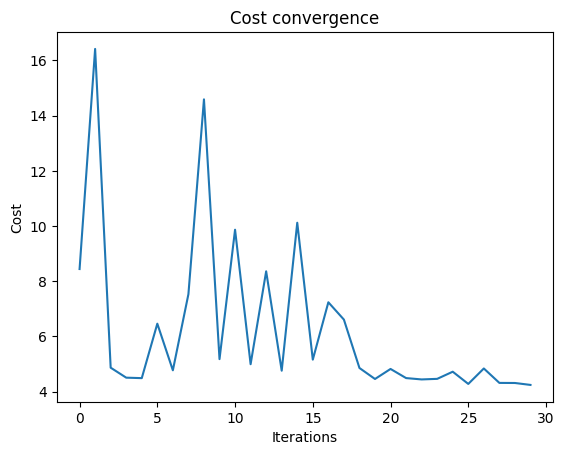

In [5]:
NUM_SHOTS = 1000
MAX_ITERATIONS = 30

# for NUM_LAYERS=3, initial_params = [γ0,γ1,γ2,β0,β1,β2] = [0.0pi, 0.5pi, 1.0pi, 1.0pi, 0.5pi, 0.0pi]
initial_params = (
    np.concatenate((np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS)))
    * math.pi
)

cost_trace = []


def evaluate_params(es, params):
    cost_estimation = es.estimate_cost(
        cost_func=lambda state: cost(state["x"]), parameters={"params": params.tolist()}
    )
    cost_trace.append(cost_estimation)
    return cost_estimation


es = ExecutionSession(
    qprog_qaoa, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)  # increment progress bar

    final_params = scipy.optimize.minimize(
        fun=lambda params: evaluate_params(es, params),
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    ).x.tolist()

print(f"Optimized parameters: {final_params}")
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

In [6]:
es = ExecutionSession(
    qprog_qaoa, execution_preferences=ExecutionPreferences(num_shots=1000)
)
res_qaoa = es.sample({"params": final_params})
es.close()

In [7]:
for sampled in res_qaoa.parsed_counts:
    x = sampled.state["x"]
    print(f"solution={x} probability={sampled.shots/NUM_SHOTS} cost={cost(x)}")

solution=[1, 0, 1, 0] probability=0.417 cost=1
solution=[1, 0, 0, 0] probability=0.19 cost=1
solution=[1, 1, 1, 0] probability=0.086 cost=6
solution=[1, 0, 0, 1] probability=0.064 cost=14
solution=[0, 1, 1, 0] probability=0.055 cost=2
solution=[0, 0, 0, 0] probability=0.047 cost=1
solution=[1, 1, 1, 1] probability=0.028 cost=23
solution=[0, 1, 0, 1] probability=0.027 cost=15
solution=[0, 0, 1, 1] probability=0.024 cost=12
solution=[1, 1, 0, 0] probability=0.02 cost=4
solution=[0, 0, 0, 1] probability=0.014 cost=12
solution=[0, 0, 1, 0] probability=0.009 cost=-1
solution=[0, 1, 1, 1] probability=0.007 cost=17
solution=[0, 1, 0, 0] probability=0.006 cost=2
solution=[1, 1, 0, 1] probability=0.005 cost=19
solution=[1, 0, 1, 1] probability=0.001 cost=16


## Approach 2: GM-QAOA

Next, we use GM-QAOA.

In [8]:
from classiq import *

total_qbit = 4


@qfunc
def initial_state(x: QArray):
    prepare_dicke_state(1, x[0:4])


def object_func(x: QArray[QBit]):
    obj = 1 * x[0] + 2 * (x[1] + x[2] + x[3]) - 3 * x[2] + 10 * x[3]
    return obj


def cost(x: QArray[QBit]):
    return object_func(x)

In [9]:
@qfunc
def cost_layer(gamma: CReal, x: QArray[QBit, total_qbit]):
    phase(cost(x), gamma)


@qfunc
def mixer_layer(beta: CReal, x: QArray):
    x_lsbs = QNum(size=x.len - 1)
    x_msb = QBit()
    within_apply(
        lambda: (invert(lambda: initial_state(x)), bind(x, [x_lsbs, x_msb]), X(x_msb)),
        lambda: control(x_lsbs == 0, lambda: RZ(-1.0 / np.pi * beta, x_msb)),
    )


@qfunc
def qaoa_ansatz(
    cost_layer: QCallable[CReal, QArray],
    mixer_layer: QCallable[CReal, QArray],
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray,
):
    repeat(
        betas.len,
        lambda i: [
            cost_layer(gammas[i], qba),
            mixer_layer(betas[i], qba),
        ],
    )

In [10]:
NUM_LAYERS = 3


@qfunc
def main(
    params: CArray[CReal, NUM_LAYERS * 2],
    x: Output[QArray[QBit, total_qbit]],
):
    allocate(x)
    gammas = params[0:NUM_LAYERS]
    betas = params[NUM_LAYERS : 2 * NUM_LAYERS]
    initial_state(x)
    qaoa_ansatz(cost_layer, mixer_layer, gammas, betas, x)

In [11]:
write_qmod(main, "gm_qaoa", decimal_precision=12, symbolic_only=False)
qprog_gmqaoa = synthesize(main)
show(qprog_gmqaoa)

Quantum program link: https://platform.classiq.io/circuit/36sSHO9NcLUSkYBK38LSus2ePWp


Optimization Progress:  43%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 13/30 [00:44<00:58,  3.42s/it]

Optimized parameters: [0.6990844681681198, 1.8512527414882123, 4.548042253484994, 3.1007941938977672, 2.6781356635974753, -0.1077908745220168]


Text(0.5, 1.0, 'Cost convergence')

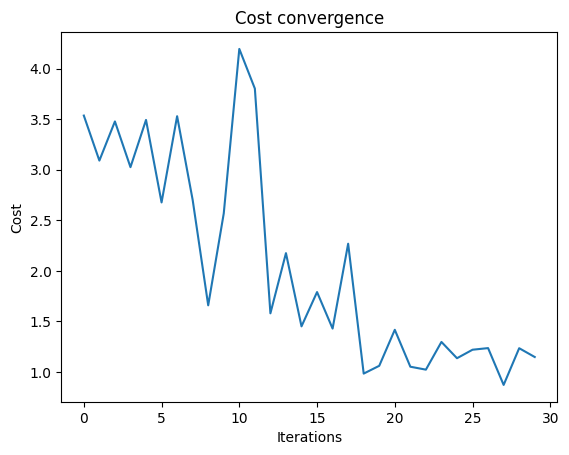

In [12]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

NUM_SHOTS = 1000
MAX_ITERATIONS = 30

# start with a linear scheduling guess
initial_params = (
    np.concatenate((np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS)))
    * math.pi
)

cost_trace = []


def evaluate_params(es, params):
    cost_estimation = es.estimate_cost(
        cost_func=lambda state: cost(state["x"]), parameters={"params": params.tolist()}
    )
    cost_trace.append(cost_estimation)
    return cost_estimation


es = ExecutionSession(
    qprog_gmqaoa, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)  # increment progress bar

    final_params = scipy.optimize.minimize(
        fun=lambda params: evaluate_params(es, params),
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    ).x.tolist()

print(f"Optimized parameters: {final_params}")
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

In [13]:
es = ExecutionSession(
    qprog_gmqaoa, execution_preferences=ExecutionPreferences(num_shots=1000)
)
res_gmqaoa = es.sample({"params": final_params})
es.close()

In [14]:
for sampled in res_gmqaoa.parsed_counts:
    x = sampled.state["x"]
    print(f"solution={x} probability={sampled.shots/NUM_SHOTS} cost={cost(x)}")

solution=[0, 0, 1, 0] probability=0.412 cost=-1
solution=[1, 0, 0, 0] probability=0.384 cost=1
solution=[0, 1, 0, 0] probability=0.132 cost=2
solution=[0, 0, 0, 1] probability=0.072 cost=12


<Axes: xlabel='x'>

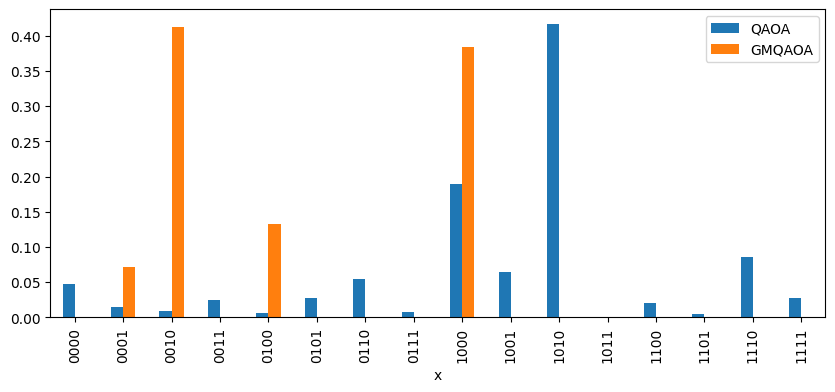

In [16]:
import pandas as pd

df_qaoa = res_qaoa.dataframe
df_gmqaoa = res_gmqaoa.dataframe

df_qaoa["x"] = df_qaoa["x"].apply(
    lambda v: "".join(map(str, v)) if isinstance(v, list) else v
)
df_gmqaoa["x"] = df_gmqaoa["x"].apply(
    lambda v: "".join(map(str, v)) if isinstance(v, list) else v
)

df_qaoa = df_qaoa.rename(columns={"probability": "QAOA"})
df_gmqaoa = df_gmqaoa.rename(columns={"probability": "GMQAOA"})
df = pd.merge(df_qaoa, df_gmqaoa, on="x", how="outer").fillna(0)
df = df[["x", "QAOA", "GMQAOA"]]
df.set_index("x").plot.bar(figsize=(10, 4))

When $ x = 0010 $, the minimum value becomes $ f = -1 $, and GM-QAOA exhibits a stronger amplification effect compared to QAOA.


## Reference
<a id='gm-qaoa'>[1]</a>: [A. Bärtschi, S. Eidenbenz. "Grover Mixers for QAOA: Shifting Complexity from Mixer Design to State Preparation" 	arXiv:2006.00354 (2020).](https://arxiv.org/abs/2006.00354)